# 0.0. IMPORTS

In [1]:
#import PANDAS 
import pandas as pd
import inflection
import math
import numpy as np
import datetime

import seaborn as sns

import matplotlib.pyplot as plt
from IPython.core.display import HTML

from IPython.display import Image 

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

### 0.1. Helper Functions

### 0.2. Load Datasets

In [2]:
#read dataset 
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)


#merge df's

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on="Store")

In [3]:
#Show the sample of the data
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
755297,113,5,2013-08-23,6535,666,1,0,0,1,d,c,20930.0,11.0,1999.0,0,NaN,NaN,NaN



# 1.0. DATA DESCRITPTION

In [4]:
#Copy the original data
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']


#Function Snake Case
snackecase = lambda x: inflection.underscore(x)

#Map of the names
cols_new = list(map(snackecase, cols_old))

#Rename name columns
df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print('Number of the rows: {}'.format(df1.shape[0]))
print('Number of the Cols: {}'.format(df1.shape[1]))

Number of the rows: 1017209
Number of the Cols: 18


## 1.3 Data Types

In [7]:
#Change the type for DATETIME the column DATE
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [8]:
#Check SUM of the NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
#competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )

#competition_open_since_month    323348
df1['competition_open_since_month'] =  df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     323348
df1['competition_open_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               508031
df1['promo2_since_week'] =  df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               508031
df1['promo2_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  508031
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] =  df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in  x['promo_interval'].split(',') else 0, axis=1)

## 1.6. Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [11]:
#Separate the numerics and categorics 

#numerics
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

#categorics
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate the dispersions

metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

In [13]:
metrics.columns = [['Attributes','Min', 'Max', 'Range', 'Media', 'Mediana', 'STD', 'Skew', 'Kurtosis']]

In [14]:
metrics

,Attributes,Min,Max,Range,Media,Mediana,STD,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


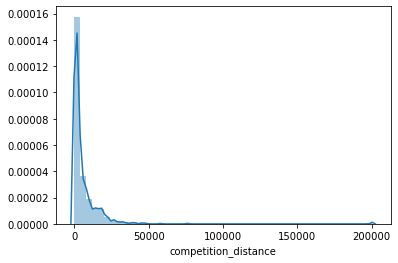

In [15]:
sns.distplot( df1['competition_distance'] )

### 1.7.2 Categorical Attributes

In [16]:
#Types of categorical
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

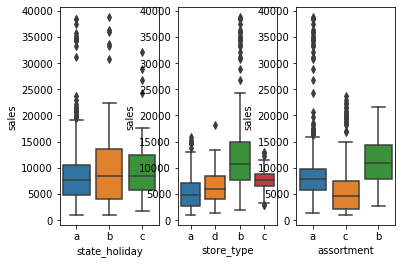

In [17]:
#Create BOX PLOT
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]


plt.subplot( 1, 3 ,1)
sns.boxplot(x='state_holiday' , y='sales', data=aux1)

plt.subplot( 1, 3 ,2)
sns.boxplot(x='store_type' , y='sales', data=aux1)

plt.subplot( 1, 3 ,3)
sns.boxplot(x='assortment' , y='sales', data=aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mind Map Hiphotese

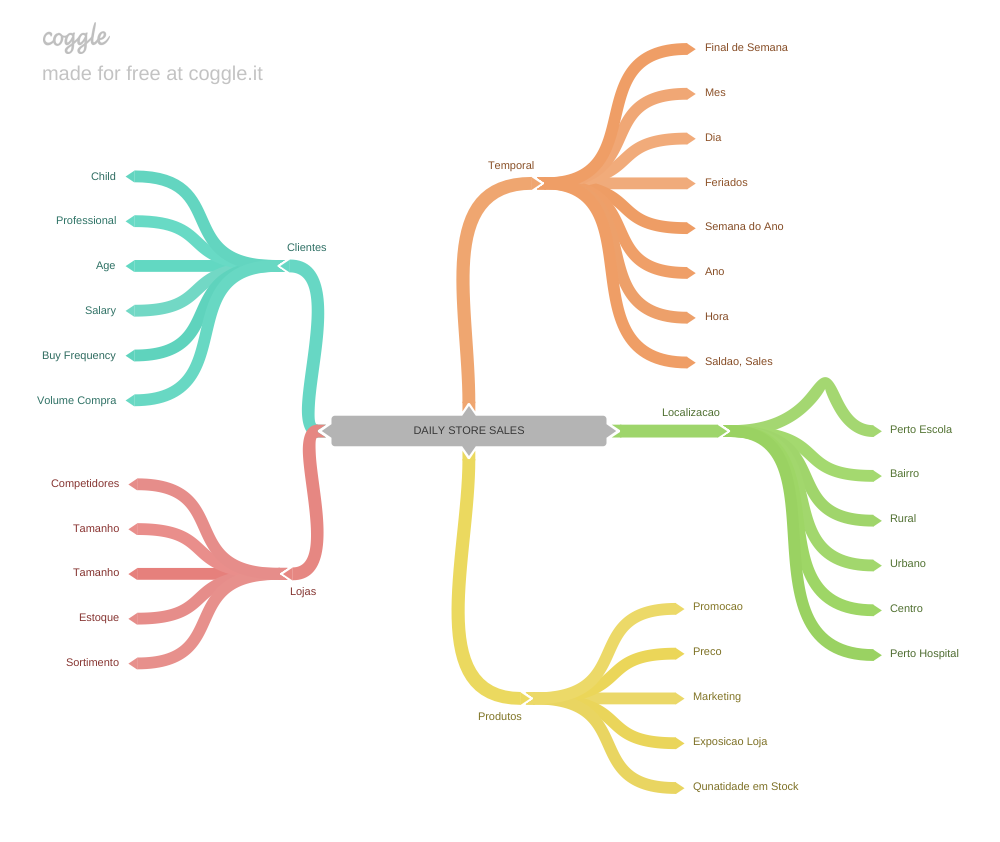

In [19]:
#import image
Image( '../img/MindMapHipothesis.png' )

## 2.2. Create Hiphoteses

### 2.2.1. Store Hiphoteses

**1.** Lojas com maior numero de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2. Products Hiphoteses

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposicao de produtos deveriam vender mais.

**3.** Lojas com produtos com menor preco deveriam vender mais

**4.** Lojas com promocoes mais agressivas (desconto maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com promocoes consecutivas deveriam vender mais.

### 2.2.3. Temporal Hiphoteses

**1.** Lojas abertas durante o oferiado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de casa mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**5.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Final List - Hiphoteses

### dica01 - Usar as variaveis que ja tem os dados disponiveis.

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o oferiado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de casa mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feaute Engineering

In [27]:
#year
#transform DATE in DATE TIME and put YEAR for colect year
df2['year'] = df2['date'].dt.year
#month
#transform DATE in DATE TIME and put MONTH for colect MONTH
df2['month'] = df2['date'].dt.month
#day
#transform DATE in DATE TIME and put DAY for colect DAY
df2['day'] = df2['date'].dt.day

#week of year
#transform DATE in DATE TIME and put WEEK OF YEAR for colect WEEK OF YEAR
df2['week_of_week'] = df2['date'].dt.weekofyear

#year week
#transform DATE in DATE TIME + STRFTIME for change the DATE
df2['week_of_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
#merge competition_open_since_month + competition_open_since_year
#put DAY = 1 for every store because not have the day in the DATE.

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days  ).astype(int)

#promo since
#Convert to STR
df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ))

df2['promo_time_week'] =  ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype( int )

#assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regulary_day')


# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [34]:
df3 = df2.copy()

In [38]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,week_of_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regulary_day,1,c,...,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regulary_day,1,a,...,Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regulary_day,1,a,...,Jul,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regulary_day,1,c,...,Jul,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regulary_day,1,a,...,Jul,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [40]:
#Open = 0 - fechada
#Sales maior que 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [41]:
#restricoes
#Depois de filtrar eu retiro a open porque vai sobrar so o que eu nao quero.
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [44]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,promo2_since_year,is_promo,year,month,day,week_of_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regulary_day,1,c,extended,1270.0,...,2015,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regulary_day,1,a,extended,570.0,...,2010,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regulary_day,1,a,extended,14130.0,...,2011,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regulary_day,1,c,extended,620.0,...,2015,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regulary_day,1,a,extended,29910.0,...,2015,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0
